# Imports

TO RUN:
- Make sure to select Runtime>Change Runtime Type>T4 GPU to use cuda
- Load in data .json
- Install pytorch_lightning

In [1]:
!pip install pytorch_lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 62.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 931.7/931.7 kB 29.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-c

In [2]:
import torch
from torch import nn
import torch.optim as optim
from torch.distributions import Normal

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import os
import pathlib
from torch.utils.data import DataLoader
from pytorch_lightning import LightningDataModule
import seaborn as sns

import json
import random
from tqdm.notebook import tqdm_notebook
from time import time
import datetime
import pickle
import matplotlib.lines as mlines

# Functions and Classes

In [3]:
def seabornSettings():
    sns.set_theme('notebook', style='whitegrid', palette='Paired', rc={"lines.linewidth": 2.5, "font.size": 10, "axes.titlesize": 12, "axes.labelsize": 12,'xtick.labelsize': 9.0, 'ytick.labelsize': 9.0, "font.family": "serif"})
    return

In [4]:
from sklearn.decomposition import PCA

def plot_latent_space_with_clusters(samples, labels, num_clusters, cluster_means, cluster_logvars, savepath,
                                    text_labels, label_colors, data_colors, epoch_num=None, x_min=None, x_max=None, y_min=None, y_max=None, dpi=100):


    # savepath = dirname + postfix + 'latent_epoch' + str(epoch)
    latent_dim = samples.shape[1]
    print(latent_dim)
    print(samples.shape)
    print(cluster_means.shape)
    print(cluster_logvars.shape)

    if latent_dim == 2:
        samples_ = samples
        cluster_means_ = cluster_means
        cluster_stds_ = torch.exp(0.5 * cluster_logvars)
        cluster_angles_ = torch.zeros(num_clusters)

    elif latent_dim > 2:
        pca = PCA(n_components=2)
        samples_ = pca.fit_transform(samples)
        cluster_means_ = pca.transform(cluster_means)
        A = pca.components_  # projection matrix
        C = torch.diag_embed(torch.exp(cluster_logvars)) # covariance matrix [num_clusters, latent_dim, latent_dim]
        C_proj = np.matmul(np.matmul(A, C), A.T) # [num_clusters, 2, 2]
        u, s, vh = np.linalg.svd(C_proj, full_matrices=True)
        cluster_stds_ = np.sqrt(s)
        cluster_angles_ = np.arctan(u[:, 0, 1] / u[:, 0, 0])

    fig, ax = plt.subplots(figsize=(6.5,4))
    markers = ['o', '^', "s", "d"]
    assert(len(markers) >= len(text_labels))

    for i in range(len(text_labels)):
        samples_i = samples_[labels == i]
        ax.scatter(samples_i[:, 0], samples_i[:, 1], marker=markers[i], s=50, label=text_labels[i], color=data_colors[i])

    for i in range(num_clusters):
        ax.plot(cluster_means_[i, 0], cluster_means_[i, 1], 'x', markersize=12, label=text_labels[i]+r' $\mu$', color=label_colors[i])
        ellipse2 = mpatches.Ellipse(xy=cluster_means_[i], width=4.0 * cluster_stds_[i, 0],
                                    height=4.0 * cluster_stds_[i, 1],  angle=cluster_angles_[i] * 180 / np.pi,
                                    label=text_labels[i]+r' $2\sigma$', color=label_colors[i], alpha=0.5)
        ax.add_patch(ellipse2)

    if latent_dim == 2:
        ax.set_xlabel('$z_1$')
        ax.set_ylabel('$z_2$')
    elif latent_dim > 2:
        ax.set_xlabel('PC$(z)_1$')
        ax.set_ylabel('PC$(z)_2$')

    if x_min is not None:
        ax.set_xlim([x_min, x_max])
    if y_min is not None:
        ax.set_ylim([y_min, y_max])
    # ax.set_xlim([-90, 80])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    # ax.legend(loc='best')
    if epoch_num is not None:
        plt.title("Latent Space Epoch {epoch_num}".format(epoch_num=epoch_num))
    else:
        plt.title("Latent Space")
    fig.tight_layout()
    fig.savefig(savepath + '.png', dpi=dpi)
    plt.close()


In [5]:
# Define encoder architecture
class Encoder(nn.Module):
    """ Neural network defining q(z | x). """

    def __init__(self, data_dim, latent_dim, hidden_dims=[32, 16, 8]):
        super().__init__()
        self.latent_dim = latent_dim
        self.fc = nn.Sequential(
            nn.Linear(in_features=data_dim, out_features=hidden_dims[0]),
            nn.Tanh(),
            nn.Linear(in_features=hidden_dims[0], out_features=hidden_dims[1]),
            nn.Tanh(),
            nn.Linear(in_features=hidden_dims[1], out_features=hidden_dims[2]),
            nn.Tanh(),
            nn.Linear(in_features=hidden_dims[2], out_features=2 * latent_dim),
        )

    def forward(self, x):
        """ Returns Normal conditional distribution for q(z | x), with mean and
        log-variance output by a neural network.

        Args:
            x: (N, data_dim) torch.tensor
        Returns:
            Normal distribution with a batch of (N, latent_dim) means and standard deviations
        """
        # print("x device:", x.get_device())
        # print("param device:", list(self.parameters())[0].get_device())

        out = self.fc(x)
        mu = out[:, 0:latent_dim]
        logsigmasq = out[:, latent_dim:]

        return mu, logsigmasq

In [6]:
# Define decoder architecture
class Decoder(nn.Module):
    """ Neural network defining p(x | z) """

    def __init__(self, data_dim, latent_dim, hidden_dims=[8, 16, 32]):
        super().__init__()
        self.data_dim = data_dim

        self.fc = nn.Sequential(
            nn.Linear(in_features=latent_dim, out_features=hidden_dims[0]),
            nn.Tanh(),
            nn.Linear(in_features=hidden_dims[0], out_features=hidden_dims[1]),
            nn.Tanh(),
            nn.Linear(in_features=hidden_dims[1], out_features=hidden_dims[2]),
            nn.Tanh(),
            nn.Linear(in_features=hidden_dims[2], out_features=data_dim),
            # nn.ReLU() 11/18 commented out because I realized this was the issue with the velocity dropping to zero
        )

    def forward(self, z):
        """ Returns Bernoulli conditional distribution of p(x | z), parametrized
        by logits.
        Args:
            z: (N, latent_dim) torch.tensor
        Returns:
            Normal distribution with a batch of (N, data_dim)
        """
        out = self.fc(z)
        mu = out
        logsigmasq = torch.ones_like(mu) * np.log(decoder_var)

        return mu, logsigmasq

In [7]:
def encoder_step(x_list, encoder_list, decoder_list):
    """
    Maps D-modality data to distributions of latent embeddings.
    :param x_list: length-D list of (N, data_dim) torch.tensor
    :param encoder_list: length-D list of Encoder
    :param decoder_list: length-D list of Decoder
    :param params: dictionary of non-DNN parameters
    :return:
        mu: (N, latent_dim) torch.tensor containing the mean of embeddings
        sigma: (N, latent_dim) torch.tensor containing the std dev of embeddings
    """

    assert(len(encoder_list) == len(decoder_list))
    # assert (len(encoder_list) == len(x_list))

    if len(encoder_list) == 1:
        mu, logsigmasq = encoder_list[0].forward(x_list[0])

    else:
        # compute distribution of qz as product of experts
        qz_inv_var = 0
        qz_mean_inv_var = 0

        for d, encoder in enumerate(encoder_list):
            mu_, logsigmasq_ = encoder.forward(x_list[d])
            qz_inv_var += torch.exp(-logsigmasq_)
            qz_mean_inv_var += mu_ * torch.exp(-logsigmasq_)

        mu = qz_mean_inv_var / qz_inv_var  # mu = qz_mean
        logsigmasq = - torch.log(qz_inv_var)  # sigma = qz_stddev

    return mu, logsigmasq

def em_step(z, mu, logsigmasq, params, update_by_batch=False):
    # compute gamma_c ~ p(c|z) for each x
    pi_c = params['pi_c']
    mu_c = params['mu_c']  # (K, Z)
    logsigmasq_c = params['logsigmasq_c']  # (K, Z)
    sigma_c = torch.exp(0.5 * logsigmasq_c)

    log_prob_zc = Normal(mu_c, sigma_c).log_prob(z.unsqueeze(dim=1)).sum(dim=2) + torch.log(pi_c)  #[N, K]
    log_prob_zc -= log_prob_zc.logsumexp(dim=1, keepdims=True)
    gamma_c = torch.exp(log_prob_zc) + em_reg
    gamma_c /= gamma_c.sum(dim=1, keepdims=True)

    denominator = torch.sum(gamma_c, dim=0).unsqueeze(1)
    mu_c = torch.einsum('nc,nz->cz', gamma_c, mu) / denominator
    logsigmasq_c = torch.log(torch.einsum('nc,ncz->cz', gamma_c, torch.square(mu.unsqueeze(dim=1) - mu_c) + torch.exp(logsigmasq).unsqueeze(dim=1))) - torch.log(denominator)

    if not update_by_batch:
        return gamma_c, mu_c, logsigmasq_c

    else:
        hist_weights = params['hist_weights']
        hist_mu_c = params['hist_mu_c']
        hist_logsigmasq_c = params['hist_logsigmasq_c']

        curr_weights = denominator
        new_weights = hist_weights + curr_weights
        new_mu_c = (hist_weights * hist_mu_c + curr_weights * mu_c) / new_weights
        new_logsigmasq_c = torch.log(hist_weights * torch.exp(hist_logsigmasq_c) +
                                      curr_weights * torch.exp(logsigmasq_c)) - torch.log(new_weights)

        params['hist_weights'] = new_weights
        params['hist_mu_c'] = new_mu_c
        params['hist_logsigmasq_c'] = new_logsigmasq_c
        return gamma_c, new_mu_c, new_logsigmasq_c



def decoder_step(x_list, z, encoder_list, decoder_list, params, mu, logsigmasq, gamma_c):
    """
    Computes a stochastic estimate of the ELBO.
    :param x_list: length-D list of (N, data_dim) torch.tensor
    :param z: MC samples of the encoded distributions
    :param encoder_list: length-D list of Encoder
    :param decoder_list: length-D list of Decoder
    :param params: dictionary of non-DNN parameters
    :return:
        elbo: (,) tensor containing the elbo estimation
    """
    assert(len(encoder_list) == len(decoder_list))

    # sigma = torch.exp(0.5 * logsigmasq)
    mu_c = params['mu_c']
    logsigmasq_c = params['logsigmasq_c']
    pi_c = params['pi_c']

    sse = 0
    elbo = 0
    elbo_terms = np.zeros(4)
    for d, decoder in enumerate(decoder_list):
        mu_, logsigmasq_ = decoder.forward(z)
        elbo += Normal(mu_, torch.exp(0.5 * logsigmasq_)).log_prob(x_list[d]).sum()
        elbo_terms[0] = Normal(mu_, torch.exp(0.5 * logsigmasq_)).log_prob(x_list[d]).sum()
        sse += torch.sum((x_list[d] - mu_) ** 2)
    # elbo += - 0.5 * sse
    elbo += - 0.5 * torch.sum(gamma_c * (logsigmasq_c + (torch.exp(logsigmasq).unsqueeze(1) + (mu.unsqueeze(1) - mu_c) ** 2) / torch.exp(logsigmasq_c)).sum(dim=2))
    elbo_terms[1] = - 0.5 * torch.sum(gamma_c * (logsigmasq_c + (torch.exp(logsigmasq).unsqueeze(1) + (mu.unsqueeze(1) - mu_c) ** 2) / torch.exp(logsigmasq_c)).sum(dim=2))
    elbo += torch.sum(gamma_c * (torch.log(pi_c) - torch.log(gamma_c))) + 0.5 * torch.sum(1 + logsigmasq)
    elbo_terms[2] = torch.sum(gamma_c * (torch.log(pi_c) - torch.log(gamma_c)))
    elbo_terms[3] = 0.5 * torch.sum(1 + logsigmasq)
    # print(elbo)
    # print(elbo_terms.sum())
    # print(elbo_terms)

    return elbo, sse, elbo_terms

# Data Loader

In [8]:
class AerocaptureDataModuleCUDA(LightningDataModule):
    def __init__(self, data_dir: str = "./", n_train: int = 5000, n_val: int = 100, n_test: int = 100,
                 train_batch: int = 1, val_batch: int = 1, test_batch: int = 1, num_workers=8):
        super().__init__()
        self.data_dir = data_dir
        self.n_train = n_train
        self.n_val = n_val
        self.n_test = n_test
        self.n_samples = n_train + n_val + n_test
        self.train_batch = train_batch
        self.val_batch = val_batch
        self.test_batch = test_batch
        self.num_workers = num_workers
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(self.device)
        self.downsampleNum = downsampleNum

    def setup(self, stage=None):

        f = open(self.data_dir)
        print('Loading File...')
        data_dict = json.load(f)
        # data_dict = pickle.load(f)
        print('...File Loaded')

        assert (self.n_samples <= len(data_dict))

        data_tr = []
        label_tr = []
        data_val = []
        label_val = []
        data_test = []
        label_test = []

        # Randomize samples
        total_samples = len(data_dict)
        sample_list = random.sample(range(total_samples), self.n_samples)

        # ASSUMES DATA IS ALREADY DOWNSAMPLED AND SCALED
        for i in tqdm_notebook(range(self.n_samples)):
            j = sample_list[i]
            this_data = np.array(data_dict[f'sample{j}']['energy'])[:]
            this_label = data_dict[f'sample{j}']['label']

            if i >= 0 and i < self.n_train:
                data_tr.append(torch.tensor(this_data, dtype=torch.float).to(self.device))
                label_tr.append(torch.tensor(this_label, dtype=torch.uint8).to(self.device))
            elif i >= self.n_train and i < self.n_train + self.n_val:
                data_val.append(torch.tensor(this_data, dtype=torch.float).to(self.device))
                label_val.append(torch.tensor(this_label, dtype=torch.uint8).to(self.device))
            else:
                data_test.append(torch.tensor(this_data, dtype=torch.float).to(self.device))
                label_test.append(torch.tensor(this_label, dtype=torch.uint8).to(self.device))

        self.train_dataset = tuple(zip(data_tr, label_tr))
        self.val_dataset = tuple(zip(data_val, label_val))
        self.test_dataset = tuple(zip(data_test, label_test))

        self.input_dim = len(self.train_dataset[0][0])

        # Assign train/val datasets for use in dataloaders
        if stage == "fit" or stage is None:
            self.train_stage_dataset = self.train_dataset
            self.val_stage_dataset = self.val_dataset

        # Assign test dataset for use in dataloader(s)
        if stage == "test" or stage is None:
            self.test_stage_dataset = self.test_dataset

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.train_batch, shuffle=False, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.val_batch, shuffle=False, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.test_batch, shuffle=False, num_workers=self.num_workers)

# Check Devices

In [9]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set default tensor type to CUDA tensors
torch.set_default_tensor_type(torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor)
#torch.set_default_tensor_type(torch.FloatTensor)
print(device)

cuda


/usr/local/lib/python3.11/dist-packages/torch/__init__.py:1236: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /pytorch/torch/csrc/tensor/python_tensor.cpp:434.)
  _C._set_default_tensor_type(t)


In [10]:
print(device)

cuda


# Settings

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
r = 0
# n_train = 1024
# n_val = 128
# n_test = 128
# For testing small batches of data
n_train = 400
n_val = 50
n_test = 50
hd1 = 64
hd2 = 32
hd3 = 16
latent_dim = 4
n_clusters = 2
lr = 1e-3
n_epochs = 1_000 # 30_000
batch_size = 64
em_reg = 1e-6
decoder_var = 1e-5

plot_interval = 500
dpi = 300

K = n_clusters
Z = latent_dim
D = 1  #num_modalities

downsampleNum = 64

# Numpy random seed
np.random.seed(r)

# PyTorch random seed for CPU
torch.manual_seed(r)

# PyTorch random seed for all GPU operations (if using CUDA)
torch.cuda.manual_seed(r)
torch.cuda.manual_seed_all(r)

# Ensure deterministic behavior for PyTorch
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Set Up Data Loader

In [13]:
from datetime import datetime
timestr = datetime.strftime(datetime.now(), "%Y%m%d_%H%M%S")

In [14]:
# Load in old data
# dirname = os.path.join("drive", "MyDrive", "GMVAE_guided_aerocapture", 'gmvae_em_aerocapture_energy_20250213_215721')
# generate new data path
dirname = os.path.join("drive", "MyDrive", "JP_gmvae_data", "gmvae_em_aerocapture_energy_"+timestr)
os.makedirs(dirname, exist_ok=True)
print("Filepath directory: " + dirname)

postfix = '_{0:d}_{1:d}_{2:d}_{3:d}_{4:d}_{5:d}_{6:d}_{7:d}_{8:d}_{9:f}_{10:d}_{11:f}_{12:f}_{13:d}_'.format(
          r, n_train, n_val, n_test, hd1, hd2, hd3, latent_dim, n_clusters, lr, batch_size, em_reg * 1e3, decoder_var, n_epochs)
print("Filepath postfix: " + postfix)

Filepath directory: drive/MyDrive/JP_gmvae_data/gmvae_em_aerocapture_energy_20250318_232316
Filepath postfix: _0_400_50_50_64_32_16_4_2_0.001000_64_0.001000_0.000010_1000_


cuda
Loading File...
...File Loaded


  0%|          | 0/500 [00:00<?, ?it/s]

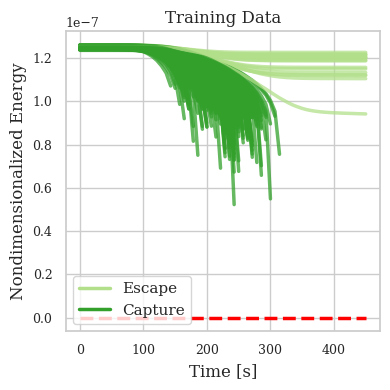

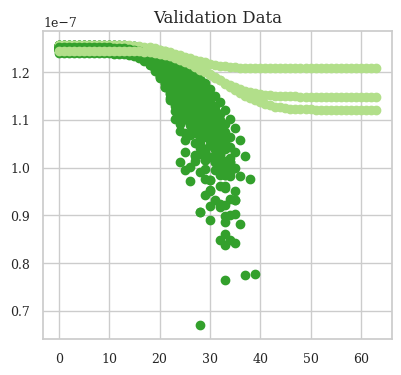

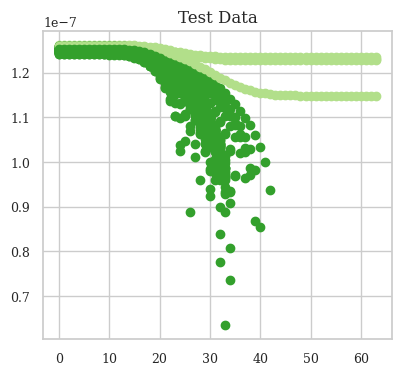

In [15]:
# data = 'jens_vel_data_correct_clusters'
# data = 'jens_shorter_data'
data = 'neptune_UOP_training_data_2500_scaled_downsampled_log_energy'
data_dir = os.path.join("drive", "MyDrive", "JP_gmvae_data", f"{data}.json")
# data_dir = f'{data}.pkl'

data_module = AerocaptureDataModuleCUDA(data_dir=data_dir, n_train=n_train, n_val=n_val, n_test=n_test,
                                  train_batch=batch_size, val_batch=batch_size, test_batch=batch_size,
                                  num_workers=0)

data_module.setup("fit")

train_loader = data_module.train_dataloader()
val_loader = data_module.val_dataloader()
test_loader = data_module.test_dataloader()
data_dim = len(train_loader.dataset[0][0])
text_labels = ['capture', 'escape']
label_colors = ['C2', 'C3']

num_train_batches = len(train_loader)

ts_plot = np.linspace(0,450,64)
seabornSettings()
fig, ax = plt.subplots(figsize=(4, 4))
for j in range(n_train):
    # print(len(train_loader.dataset[j][0].cpu()))
    ax.plot(ts_plot, train_loader.dataset[j][0].cpu(), color=label_colors[train_loader.dataset[j][1].cpu()], alpha=0.75)

eline = mlines.Line2D([], [], color='C2', label='Escape')
cline = mlines.Line2D([], [], color='C3', label='Capture')
plt.legend(handles=[eline, cline])
plt.hlines(0, 0, ts_plot[-1], colors='r', linestyles='dashed')
plt.xlabel("Time [s]")
plt.ylabel("Nondimensionalized Energy")
plt.title("Training Data")
plt.tight_layout()
fig.savefig(os.path.join(dirname, 'train_data'+postfix+'.png'), dpi=dpi)

fig, ax = plt.subplots(figsize=(4.5, 4))
for j in range(n_val):
    ax.scatter(np.arange(downsampleNum), val_loader.dataset[j][0].cpu(), color=label_colors[val_loader.dataset[j][1].cpu()])
plt.title("Validation Data")
fig.savefig(os.path.join(dirname, 'val_data'+postfix+'.png'), dpi=dpi)

fig, ax = plt.subplots(figsize=(4.5, 4))
for j in range(n_test):
    ax.scatter(np.arange(downsampleNum), test_loader.dataset[j][0].cpu(), color=label_colors[test_loader.dataset[j][1].cpu()])
plt.title("Test Data")
fig.savefig(os.path.join(dirname, 'test_data'+postfix+'.png'), dpi=dpi)

# Print number of capture / escape in each training set TODO


# Run GMVAE

In [16]:
# initialize latent GMM model parameters
params = {}
pi_variables = torch.zeros(K).clone().detach().requires_grad_(True)
params['pi_c'] = torch.ones(K) / K
params['mu_c'] = torch.rand((K, Z)) * 2.0 - 1.0
params['logsigmasq_c'] = torch.zeros((K, Z))

# initialize neural networks
encoder_list = []
decoder_list = []
trainable_parameters = []
trainable_parameters.append(pi_variables)

for _ in range(D):
    encoder = Encoder(data_dim=data_dim, latent_dim=latent_dim, hidden_dims=[hd1, hd2, hd3])
    decoder = Decoder(data_dim=data_dim, latent_dim=latent_dim, hidden_dims=[hd3, hd2, hd1])
    encoder_list.append(encoder)
    decoder_list.append(decoder)
    trainable_parameters += list(encoder.parameters()) + list(decoder.parameters())

optimizer = optim.Adam(trainable_parameters, lr=lr)

# training

import time
ts = time.time()
tic = time.perf_counter()

train_loss = torch.zeros(n_epochs)
train_elbo_terms = torch.zeros((n_epochs, 4)) # 4 ELBO terms
val_elbo_terms = torch.zeros((n_epochs, 4)) # 4 ELBO terms
val_loss = torch.zeros(n_epochs)
pi_history = torch.zeros((n_epochs, K))
train_mse_history = torch.zeros(n_epochs)
val_mse_history = torch.zeros(n_epochs)
min_val_loss = torch.inf
seabornSettings()

for epoch in range(n_epochs):
    ti = time.time()
    for encoder in encoder_list:
        encoder.train()
    for decoder in decoder_list:
        decoder.train()

    train_elbo = 0
    train_mse = 0
    train_elbo_term = np.zeros(4)
    params['hist_weights'] = torch.zeros((K, 1))
    params['hist_mu_c'] = torch.zeros((K, latent_dim))
    params['hist_logsigmasq_c'] = torch.zeros((K, latent_dim))

    for (batch_idx, batch) in enumerate(train_loader):
        batch_x, _ = batch
        x_list = [batch_x]  # assume D=2 and each modality has data_dim
        optimizer.zero_grad()
        pi_c = torch.exp(pi_variables) / torch.sum(torch.exp(pi_variables))
        params['pi_c'] = pi_c

        mu, logsigmasq = encoder_step(x_list, encoder_list, decoder_list)
        sigma = torch.exp(0.5 * logsigmasq)
        eps = Normal(0, 1).sample(mu.shape)
        z = mu + eps * sigma

        with torch.no_grad():
            gamma_c, mu_c, logsigmasq_c = em_step(z, mu, logsigmasq, params, update_by_batch=True)
        params['mu_c'] = mu_c
        params['logsigmasq_c'] = logsigmasq_c

        elbo, sse, elbo_terms = decoder_step(x_list, z, encoder_list, decoder_list, params, mu, logsigmasq, gamma_c)
        train_elbo += elbo.item()
        train_elbo_term += elbo_terms
        train_mse += sse.item()
        loss = - elbo / batch_x.shape[0]
        loss.backward()
        optimizer.step()

    for encoder in encoder_list:
        encoder.eval()
    for decoder in decoder_list:
        decoder.eval()

    if epoch % plot_interval == 0 or epoch == n_epochs:
        # Plot the first two dimensions of the latents
        with torch.no_grad():
            means = []
            samples = []
            labels = []
            for batch in train_loader:
                batch_x, batch_label = batch
                x_list = [batch_x]
                mean, logsigmasq = encoder_step(x_list, encoder_list, decoder_list)
                sigma = torch.exp(0.5 * logsigmasq)
                eps = Normal(0, 1).sample(mean.shape)
                z = mean + eps * sigma
                means.append(mean)
                samples.append(z)
                labels.append(batch_label)

        means = torch.vstack(means).cpu()
        samples = torch.vstack(samples).cpu()
        labels = torch.hstack(labels).cpu()

        savepath = os.path.join(dirname, "latent_samples_epoch_" + str(epoch) + postfix)
        plot_latent_space_with_clusters(samples, labels, K, mu_c.cpu(), logsigmasq_c.cpu(), savepath, text_labels, label_colors, label_colors, epoch, dpi=dpi)

        savepath = os.path.join(dirname, "latent_means_epoch_" + str(epoch) + postfix)
        plot_latent_space_with_clusters(means, labels, K, mu_c.cpu(), logsigmasq_c.cpu(), savepath, text_labels, label_colors, label_colors, epoch, dpi=dpi)


        # plot samples from generative model
        n_gen = n_train
        cluster_probs = params['pi_c'].cpu().detach().numpy() #
        fig, ax = plt.subplots(figsize=(4.5, 4))
        for j in range(n_gen):
            c = np.random.choice(K, p=cluster_probs)
            mu_c = params['mu_c'][c].clone().detach()
            sigma_c = torch.exp(0.5 * params['logsigmasq_c'][c]).clone().detach()
            z = Normal(0, 1).sample(mu_c.shape) * sigma_c + mu_c
            mu_x = decoder.forward(z)[0]
            ax.plot(mu_x.cpu().detach().numpy())
        fig.savefig(os.path.join(dirname, "generate_samples_" + str(epoch) + postfix+ '.png'), dpi=dpi)
        plt.close()


    val_elbo = 0
    val_mse = 0
    val_elbo_term = np.zeros(4)
    with torch.no_grad():
        for (batch_idx, batch) in enumerate(val_loader):
            batch_x, _ = batch
            x_list = [batch_x]
            mu, logsigmasq = encoder_step(x_list, encoder_list, decoder_list)
            sigma = torch.exp(0.5 * logsigmasq)
            eps = Normal(0, 1).sample(mu.shape)
            z = mu + eps * sigma
            with torch.no_grad():
                gamma_c, _, _ = em_step(z, mu, logsigmasq, params)
            elbo, sse, elbo_items = decoder_step(x_list, z, encoder_list, decoder_list, params, mu, logsigmasq, gamma_c)
            val_elbo += elbo.item()
            val_mse += sse.item()
            val_elbo_term += elbo_items

    train_elbo /= len(train_loader.dataset)
    train_elbo_term = torch.tensor(train_elbo_term) / len(train_loader.dataset)
    val_elbo /= len(val_loader.dataset)
    val_elbo_term = torch.tensor(val_elbo_term) / len(val_loader.dataset)
    train_mse /= len(train_loader.dataset)
    val_mse /= len(val_loader.dataset)

    tf = time.time()
    toc = time.perf_counter()
    print('====> Epoch: {} Train ELBO: {:.4f} Val ELBO: {:.4f}, Epoch Time (s): {:.2f}, Total Time (hrs): {:.4f}'.format(epoch, train_elbo, val_elbo, tf-ti, (toc-tic)/60/60))

    train_loss[epoch] = - train_elbo
    val_loss[epoch] = - val_elbo
    train_elbo_terms[epoch,:] = - train_elbo_term
    val_elbo_terms[epoch,:] = - val_elbo_term
    pi_history[epoch] = params['pi_c']
    train_mse_history[epoch] = train_mse
    val_mse_history[epoch] = val_mse

    if - val_elbo < min_val_loss:
        min_val_loss = - val_elbo
        torch.save(params['pi_c'], os.path.join(dirname, 'gmm_params_pi'+ postfix + '.pt'))
        torch.save(params['mu_c'], os.path.join(dirname, 'gmm_params_mu'+ postfix + '.pt'))
        torch.save(params['logsigmasq_c'], os.path.join(dirname, 'gmm_params_logsigmasq'+ postfix + '.pt'))
        torch.save(encoder.state_dict(), os.path.join(dirname, 'encoder'+ postfix + '.pt'))
        torch.save(decoder.state_dict(), os.path.join(dirname, 'decoder'+ postfix + '.pt'))

    if epoch % plot_interval == 0 or epoch == n_epochs:
      # Plot the training and validation loss vs. epoch number
      plt.figure(figsize=(4.5, 4))
      # const = min(min(train_loss), min(val_loss))
      train_loss_adjusted = train_loss
      val_loss_adjusted = val_loss
      plt.plot(train_loss_adjusted.cpu()[:epoch], label='train')
      # print(train_loss_adjusted.cpu()[:epoch])
      plt.plot(val_loss_adjusted.cpu()[:epoch], label='val')
      plt.yscale('symlog')
      plt.xlabel("number of epochs")
      plt.ylabel("loss")
      plt.title("Negative Loss")
      plt.legend()
      plt.tight_layout()
      plt.savefig(os.path.join(dirname, 'elbo_'+ str(epoch)+postfix+'.png'), dpi=dpi)
      plt.close()

      # Plot each term of the training loss and validation loss
      plt.figure(figsize=(4.5, 4))
      labels = ["Reconstruction", "GMM Reg", "Prob Reg", "Encoder Var"]
      for ii in range(4):
        train_loss_adjusted = train_elbo_terms[:epoch, ii]
        val_loss_adjusted = val_elbo_terms[:epoch, ii]
        plt.plot(train_loss_adjusted.cpu()[:epoch], label=f"{labels[ii]}: Train")
        plt.plot(val_loss_adjusted.cpu()[:epoch], label=f"{labels[ii]}: Val", linestyle='--')
      plt.xlabel("number of epochs")
      plt.yscale('symlog')
      plt.ylabel("loss")
      plt.title("Negative Loss Terms")
      plt.legend()
      plt.tight_layout()
      plt.savefig(os.path.join(dirname, 'elbo_terms_'+ str(epoch)+postfix+'.png'), dpi=dpi)
      plt.close()

      # Plot the training and validation mse vs. epoch number
      plt.figure(figsize=(4.5, 4))
      plt.semilogy(train_mse_history.cpu().detach().numpy()[:epoch], label='train')
      plt.semilogy(val_mse_history.cpu().detach().numpy()[:epoch], label='val')
      plt.xlabel("number of epochs")
      plt.legend()
      plt.tight_layout()
      plt.savefig(os.path.join(dirname, 'reconst_mse_'+ str(epoch)+postfix+'.png'), dpi=dpi)
      plt.close()

      # Plot the history of pi
      plt.figure(figsize=(4.5, 4))
      for i in range(K):
          plt.plot(pi_history[:, i].cpu().detach().numpy()[:epoch], label=r'$\pi$' + str(i+1))
      plt.xlabel("number of epochs")
      plt.legend()
      plt.tight_layout()
      plt.savefig(os.path.join(dirname, 'pi_'+ str(epoch)+postfix+'.png'), dpi=dpi)
      plt.close()


te = time.time()
import datetime
duration = datetime.timedelta(seconds=te - ts)
print("Training took ", duration)

# Save off pi_history, train_loss, val_loss, train_mse_history, val_mse_history
torch.save(pi_history, os.path.join(dirname, 'pi_history'+ postfix + '.pt'))
torch.save(train_loss, os.path.join(dirname, 'train_loss'+ postfix + '.pt'))
torch.save(val_loss, os.path.join(dirname, 'val_loss'+ postfix + '.pt'))
torch.save(train_elbo_terms, os.path.join(dirname, 'train_elbo_terms'+ postfix + '.pt'))
torch.save(val_elbo_terms, os.path.join(dirname, 'val_elbo_terms'+ postfix + '.pt'))
torch.save(train_mse_history, os.path.join(dirname, 'train_mse_history'+ postfix + '.pt'))
torch.save(val_mse_history, os.path.join(dirname, 'val_mse_history'+ postfix + '.pt'))

ValueError: Expected value argument (Tensor of shape (64, 1, 4)) to be within the support (Real()) of the distribution Normal(loc: torch.Size([2, 4]), scale: torch.Size([2, 4])), but found invalid values:
tensor([[[    nan,     nan,     nan,     nan]],

        [[    nan,     nan,     nan,     nan]],

        [[    nan,     nan,     nan,     nan]],

        [[    nan,     nan,     nan,     nan]],

        [[    nan,     nan,     nan,     nan]],

        [[    nan,     nan,     nan,     nan]],

        [[    nan,     nan,     nan,     nan]],

        [[    nan,     nan,     nan,     nan]],

        [[    nan,     nan,     nan,     nan]],

        [[    nan,     nan,     nan,     nan]],

        [[    nan,     nan,     nan,     nan]],

        [[    nan,     nan,     nan,     nan]],

        [[    nan,     nan,     nan,     nan]],

        [[    nan,     nan,     nan,     nan]],

        [[    nan,     nan,     nan,     nan]],

        [[    nan,     nan,     nan,     nan]],

        [[    nan,     nan,     nan,     nan]],

        [[    nan,     nan,     nan,     nan]],

        [[-0.4870, -1.4385, -0.5932,  1.6553]],

        [[    nan,     nan,     nan,     nan]],

        [[    nan,     nan,     nan,     nan]],

        [[    nan,     nan,     nan,     nan]],

        [[    nan,     nan,     nan,     nan]],

        [[    nan,     nan,     nan,     nan]],

        [[    nan,     nan,     nan,     nan]],

        [[    nan,     nan,     nan,     nan]],

        [[    nan,     nan,     nan,     nan]],

        [[    nan,     nan,     nan,     nan]],

        [[    nan,     nan,     nan,     nan]],

        [[    nan,     nan,     nan,     nan]],

        [[    nan,     nan,     nan,     nan]],

        [[    nan,     nan,     nan,     nan]],

        [[    nan,     nan,     nan,     nan]],

        [[    nan,     nan,     nan,     nan]],

        [[-0.9890,  1.6773, -0.7591, -1.3747]],

        [[    nan,     nan,     nan,     nan]],

        [[    nan,     nan,     nan,     nan]],

        [[    nan,     nan,     nan,     nan]],

        [[    nan,     nan,     nan,     nan]],

        [[    nan,     nan,     nan,     nan]],

        [[    nan,     nan,     nan,     nan]],

        [[    nan,     nan,     nan,     nan]],

        [[    nan,     nan,     nan,     nan]],

        [[    nan,     nan,     nan,     nan]],

        [[    nan,     nan,     nan,     nan]],

        [[    nan,     nan,     nan,     nan]],

        [[    nan,     nan,     nan,     nan]],

        [[    nan,     nan,     nan,     nan]],

        [[    nan,     nan,     nan,     nan]],

        [[    nan,     nan,     nan,     nan]],

        [[    nan,     nan,     nan,     nan]],

        [[ 0.3841,  1.3067,  0.6684,  1.1400]],

        [[    nan,     nan,     nan,     nan]],

        [[    nan,     nan,     nan,     nan]],

        [[    nan,     nan,     nan,     nan]],

        [[    nan,     nan,     nan,     nan]],

        [[    nan,     nan,     nan,     nan]],

        [[    nan,     nan,     nan,     nan]],

        [[    nan,     nan,     nan,     nan]],

        [[    nan,     nan,     nan,     nan]],

        [[    nan,     nan,     nan,     nan]],

        [[    nan,     nan,     nan,     nan]],

        [[    nan,     nan,     nan,     nan]],

        [[    nan,     nan,     nan,     nan]]], requires_grad=True)

# Load and Plot Results

In [ ]:
epoch = 29999
epoch = 30_000
params = {}
encoder = Encoder(data_dim=data_dim, latent_dim=latent_dim, hidden_dims=[hd1, hd2, hd3]).to("cuda")
decoder = Decoder(data_dim=data_dim, latent_dim=latent_dim, hidden_dims=[hd3, hd2, hd1]).to("cuda")
encoder_list = [encoder]
decoder_list = [decoder]

device = next(encoder.parameters()).device
# Load in training history metrics
pi_history = torch.load(os.path.join(dirname, 'pi_history'+ postfix + '.pt'))
train_loss = torch.load(os.path.join(dirname, 'train_loss'+ postfix + '.pt'))
val_loss = torch.load(os.path.join(dirname, 'val_loss'+ postfix + '.pt'))
train_elbo_terms = torch.load(os.path.join(dirname, 'train_elbo_terms'+ postfix + '.pt'))
val_elbo_terms = torch.load(os.path.join(dirname, 'val_elbo_terms'+ postfix + '.pt'))
train_mse_history = torch.load(os.path.join(dirname, 'train_mse_history'+ postfix + '.pt'))
val_mse_history = torch.load(os.path.join(dirname, 'val_mse_history'+ postfix + '.pt'))


text_labels = ['Capture', 'Escape']
data_colors = ['C3', 'C1']
label_colors = ['C0', 'C2']

# Plot training history
# Plot the training and validation loss vs. epoch number
plt.figure(figsize=(4, 4))
const = min(min(train_loss), min(val_loss))
print(const)
# const = min(10, const)
train_loss_adjusted = train_loss
val_loss_adjusted = val_loss
plt.plot(train_loss_adjusted.cpu(), label='Training')
plt.plot(val_loss_adjusted.cpu(), label='Validation')
plt.xlabel("Number of Epochs")
plt.ylabel("Negative Loss")
# plt.title("Negative Loss")
plt.yscale('symlog')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(dirname, 'elbo_'+ str(epoch)+postfix+'.png'), dpi=dpi)
# plt.close()


 # Plot each term of the training loss and validation loss
plt.figure(figsize=(4.5, 4))
labels = ["Reconstruction", "GMM Reg", "Prob Reg", "Encoder Var"]
for ii in range(4):
  # print(train_elbo_terms.cpu()[ii, :epoch])
  # print(len(train_elbo_terms.cpu()[ii, :epoch]))
  train_loss_adjusted = train_elbo_terms[:, ii]
  val_loss_adjusted = val_elbo_terms[:, ii]
  plt.plot(train_loss_adjusted.cpu()[:], label=f"{labels[ii]}: Train")
  plt.plot(val_loss_adjusted.cpu()[:], label=f"{labels[ii]}: Val", linestyle='--')
plt.xlabel("number of epochs")
plt.ylabel("loss")
plt.title("Negative Loss Terms")
plt.yscale('symlog')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(dirname, 'elbo_terms_'+ str(epoch)+postfix+'.png'), dpi=dpi)
plt.close()


 # Plot the sum of each term of the training loss and validation loss
plt.figure(figsize=(4.5, 4))
  # print(train_elbo_terms.cpu()[ii, :epoch])
  # print(len(train_elbo_terms.cpu()[ii, :epoch]))
train_loss_adjusted = train_elbo_terms.sum(axis=1)
val_loss_adjusted = val_elbo_terms.sum(axis=1)
plt.plot(train_loss_adjusted.cpu()[:], label=f"Train")
plt.plot(val_loss_adjusted.cpu()[:], label=f"Val", linestyle='--')
plt.xlabel("number of epochs")
plt.ylabel("loss")
plt.title("Sum of ELBO Terms")
plt.yscale('symlog')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(dirname, 'elbo_terms_sum_'+ str(epoch)+postfix+'.png'), dpi=dpi)
plt.close()

# Plot the training and validation mse vs. epoch number
plt.figure(figsize=(4.5, 4))
plt.semilogy(train_mse_history.cpu().detach().numpy(), label='train')
plt.semilogy(val_mse_history.cpu().detach().numpy(), label='val')
plt.xlabel("number of epochs")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(dirname, 'reconst_mse_'+ str(epoch)+postfix+'.png'), dpi=dpi)
# plt.close()

# Plot the history of pi
plt.figure(figsize=(4, 4))
colors = ['C0', 'C2']
for i in range(K):
    plt.plot(pi_history[:, i].cpu().detach().numpy(), label=text_labels[i]+r' $\pi$', color=colors[i])
plt.xlabel("Number of Epochs")
plt.ylabel("Predicted Cluster Probability")
plt.axhline(y=0.649, color='C1', linestyle='--', label='True Escape Probability')
plt.axhline(y=0.351, color='C3', linestyle='--', label='True Capture Probability')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(dirname, 'pi_'+ str(epoch)+postfix+'.png'), dpi=dpi)
# plt.close()

# Load best model saved
params['pi_c'] = torch.load(os.path.join(dirname, 'gmm_params_pi'+ postfix + '.pt'))
params['mu_c'] = torch.load(os.path.join(dirname, 'gmm_params_mu'+ postfix + '.pt'))
params['logsigmasq_c'] = torch.load(os.path.join(dirname, 'gmm_params_logsigmasq'+ postfix + '.pt'))
encoder.load_state_dict(torch.load(os.path.join(dirname, 'encoder'+ postfix + '.pt')))
decoder.load_state_dict(torch.load(os.path.join(dirname, 'decoder'+ postfix + '.pt')))

encoder.eval()
decoder.eval()


# run one last EM step and plot training data in latent space
for encoder in encoder_list:
    encoder.eval()

with torch.no_grad():
    means = []
    samples = []
    labels = []
    params['hist_weights'] = torch.zeros((K, 1))
    params['hist_mu_c'] = torch.zeros((K, latent_dim))
    params['hist_logsigmasq_c'] = torch.zeros((K, latent_dim))
    for batch in train_loader:
        batch_x, batch_label = batch
        x_list = [batch_x]
        mu, logsigmasq = encoder_step(x_list, encoder_list, decoder_list)
        sigma = torch.exp(0.5 * logsigmasq)
        eps = Normal(0, 1).sample(mu.shape)
        z = mu + eps * sigma
        with torch.no_grad():
            gamma_c, mu_c, logsigmasq_c = em_step(z, mu, logsigmasq, params, update_by_batch=True)
        params['mu_c'] = mu_c
        params['logsigmasq_c'] = logsigmasq_c

        means.append(mu)
        samples.append(z)
        labels.append(batch_label)

means = torch.vstack(means).cpu()
samples = torch.vstack(samples).cpu()
labels = torch.hstack(labels).cpu()


savepath = os.path.join(dirname, "BEST_latent_samples"+postfix)
plot_latent_space_with_clusters(samples, labels, K, mu_c.cpu(), logsigmasq_c.cpu(), savepath, text_labels, label_colors, data_colors, dpi=dpi)

savepath = os.path.join(dirname, "BEST_latent_means"+postfix)
plot_latent_space_with_clusters(means, labels, K, mu_c.cpu(), logsigmasq_c.cpu(), savepath, text_labels, label_colors, data_colors, dpi=dpi)

# plot test data in latent space
with torch.no_grad():
    test_means = []
    test_labels = []
    for batch in test_loader:
        batch_x, batch_label = batch
        x_list = [batch_x]
        mean, _ = encoder_step(x_list, encoder_list, decoder_list)
        test_means.append(mean)
        test_labels.append(batch_label)

test_means = torch.vstack(test_means).cpu()
test_labels = torch.hstack(test_labels).cpu()


savepath = os.path.join(dirname, "BEST_test_latent_samples"+postfix)
plot_latent_space_with_clusters(test_means, test_labels, K, mu_c.cpu(), logsigmasq_c.cpu(), savepath, text_labels, label_colors, data_colors, dpi=dpi)

# plot decoding results from cluster means # todo: expand this function for multi-modal data
fig, ax = plt.subplots(figsize=(4.5, 4))
for i in range(K):
    # with torch.no_grad:
    x_mean = decoder.forward(params['mu_c'][i])[0]
    ax.plot(x_mean.cpu().detach().numpy(), label="decoded $\mu$"+str(i+1))
ax.legend()
plt.title("Decoded Means")
fig.savefig(os.path.join(dirname, "BEST_decoded_means"+postfix+'.png'), dpi=dpi)
# plt.close()

# plot samples from generative model
n_gen = n_train
cluster_probs = params['pi_c'].cpu().detach().numpy()
fig, ax = plt.subplots(figsize=(4.5, 4))
for j in range(n_gen):
    c = np.random.choice(K, p=cluster_probs)
    # print(c)
    mu_c = params['mu_c'][c].cpu().clone().detach()
    sigma_c = torch.exp(0.5 * params['logsigmasq_c'][c]).cpu().clone().detach()
    z = Normal(0, 1).sample(mu_c.shape).cpu().clone().detach() * sigma_c + mu_c
    # print(z)
    mu_x = decoder.forward(z.cuda())[0].cpu().clone().detach()
    sigma_x = torch.exp(0.5 * decoder.forward(z.cuda())[1])
    sample_x = Normal(0, 1).sample(mu_x.shape).cpu().clone().detach() * sigma_x.cpu().clone().detach() + mu_x
    ax.plot(sample_x.cpu().detach().numpy())
plt.title("Generated Samples")
fig.savefig(os.path.join(dirname, "BEST_generate_samples"+postfix+'.png'), dpi=dpi)
# plt.close()

np.savez(dirname + postfix, train_loss=train_loss.cpu().detach().numpy(), val_loss=val_loss.cpu().detach().numpy(),
      train_mse=train_mse_history.cpu().detach().numpy(), val_mse=val_mse_history.cpu().detach().numpy(),
      pi_history=pi_history.cpu().detach().numpy(),
      cluster_probs=params['pi_c'].cpu().detach().numpy(),
      cluster_means=params['mu_c'].cpu().detach().numpy(),
      cluster_vars=torch.exp(params['logsigmasq_c']).cpu().detach().numpy())


print("Training data size", n_train)
print("Fraction of downward curves:", (torch.sum(labels == 0) / n_train).item())
print("Cluster 1 probability:", cluster_probs.min().item())
print("Error:", str(abs(cluster_probs.min().item() - 0.2573)))